In [2]:
import scipy.io as scio 
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from skimage.color import rgb2grey
from sklearn.feature_extraction import image
import skimage.measure
from sklearn import cluster, datasets, mixture
from sklearn.decomposition import PCA 
import matplotlib.cm as cm
from configparser import ConfigParser
from sklearn.cluster import KMeans
import sompy
import skfuzzy as skf

In [3]:
pavia = {'rgb': scio.loadmat('PaviaRGB.mat')['PaviaRGB'],
         'color_map' : scio.loadmat('PaviaColorMap.mat')['PaviaColorMap'],
         'ground_truth' : scio.loadmat('PaviaGrTruth.mat')['PaviaGrTruth'],
         'ground_truth_mask' : scio.loadmat('PaviaGrTruthMask.mat')['PaviaGrTruthMask'],
         'wavelengths' : scio.loadmat('PaviaWavelengths.mat')['PaviaWavelengths'],
        }
sanbar = {'rgb': scio.loadmat('SanBarRGB.mat')['SanBarRGB'],
          'wavelengths': scio.loadmat('SanBarWavelengths.mat')['WaveLengths'],
          'hyperimage': scio.loadmat('SanBarHyperIm.mat')['SanBarIm88x400'],
         }

## Loading up Config Parameters 

config = ConfigParser()
config.read('appConfig.ini')

[]

In [1]:
#Pavia RGB

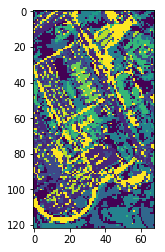

In [9]:
Img = pavia['rgb']
downsample = ski.measure.block_reduce(Img, (5,5,1), np.max)
[l,w,h] = downsample.shape
down = downsample.reshape(l*w,h)
sp = cluster.SpectralClustering(n_clusters=10, eigen_solver='arpack', affinity="nearest_neighbors")
sp.fit_predict(down)
labels = sp.labels_
outlabels = labels.reshape(l,w)
plt.imshow(outlabels)

In [10]:
np.max

<function numpy.core.fromnumeric.amax>

In [13]:
def label_show(im):
    """Displays input image with color"""
    cmap = cm.get_cmap('tab20c', 9)
    plt.imshow(im, cmap=cmap, vmin=0, vmax=9)
    plt.colorbar(ticks=np.linspace(0,9,10))
    plt.show()

In [4]:
#define the functions

In [4]:
def k_means_clustering(n_clusters=2,inp_image=pavia['rgb']):
    if inp_image is None:
        print("Empty Input. Exiting")
        return None 
    # Create K Means Model 
    k_means = KMeans(n_clusters=n_clusters)
    shape = inp_image.shape
    # Fit on Input Image 
    k_means.fit(inp_image.flatten().reshape(shape[0]*shape[1],shape[2]))
    # Get Cluster Labels
    inp_clustered = k_means.labels_.astype(float)
    
    return inp_clustered.reshape(shape[0]*shape[1],1).reshape(shape[0],shape[1])


def fuzzy_c_means(n_clusters=2, inp_image=pavia['rgb']):
    if inp_image is None:
        print("Empty Input. Exiting")
        return 
    
    shape = inp_image.shape
    # Create and Train on FCM Model 
    centers, u, u0, d, jm, n_iters, fpc = skf.cluster.cmeans(
        inp_image.flatten().reshape(shape[0]*shape[1],shape[2]).T,
        c=n_clusters,
        m=2,
        error=0.005,
        maxiter=1000,
        init=None,
        seed=42
    )
    # Get Cluster Labels with Max Porbability 
    clust = np.argmax(u, axis=0).astype(float)
    
    return clust.reshape(shape[0]*shape[1],1).reshape(shape[0],shape[1])


def gaussian_mixture_model(n_clusters=2,inp_image=pavia['rgb']):
    shape = inp_image.shape
    inp_image = inp_image.flatten().reshape(shape[0]*shape[1],shape[2])
    # Create Gaussian Mixture Model with Config Parameters
    gmm = GaussianMixture(
        n_components=n_clusters, covariance_type=config['GMM']['COVARIANCE_TYPE'], n_init=5,
        max_iter=int(config['GMM']['MAX_ITER']), random_state=int(config['GMM']['RANDOM_STATE']))
    # Fit on Input Image
    gmm.fit(X=inp_image)
    # Get Cluster Labels 
    clust = gmm.predict(X=inp_image)
    
    return clust.reshape(shape[0]*shape[1],1).reshape(shape[0],shape[1])

def SOM(n_clusters=5, n_job=5, map_dim=20, inp_image=pavia['rgb']):

    # Calculate the map
    mapsize = [map_dim,map_dim]
    shape = inp_image.shape
    data = inp_image.flatten().reshape(shape[0]*shape[1],shape[2])
    som = sompy.SOMFactory.build(data, mapsize)  
    som.train(n_job=n_job, verbose=None)
    
    #calculating clusters
    cl = som.cluster(n_clusters=n_clusters)
    
    # calculating which pixel is associated which cluster
    project_data = som.project_data(data)
    clust = np.zeros((shape[0], shape[1]))
    for i, q in enumerate(project_data):
        temp = cl[q]
        clust[np.unravel_index(i, dims=((shape[0], shape[1])))] = temp

    return clust

maxtrainlen %d inf
maxtrainlen %d inf


C:\Users\bripo\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


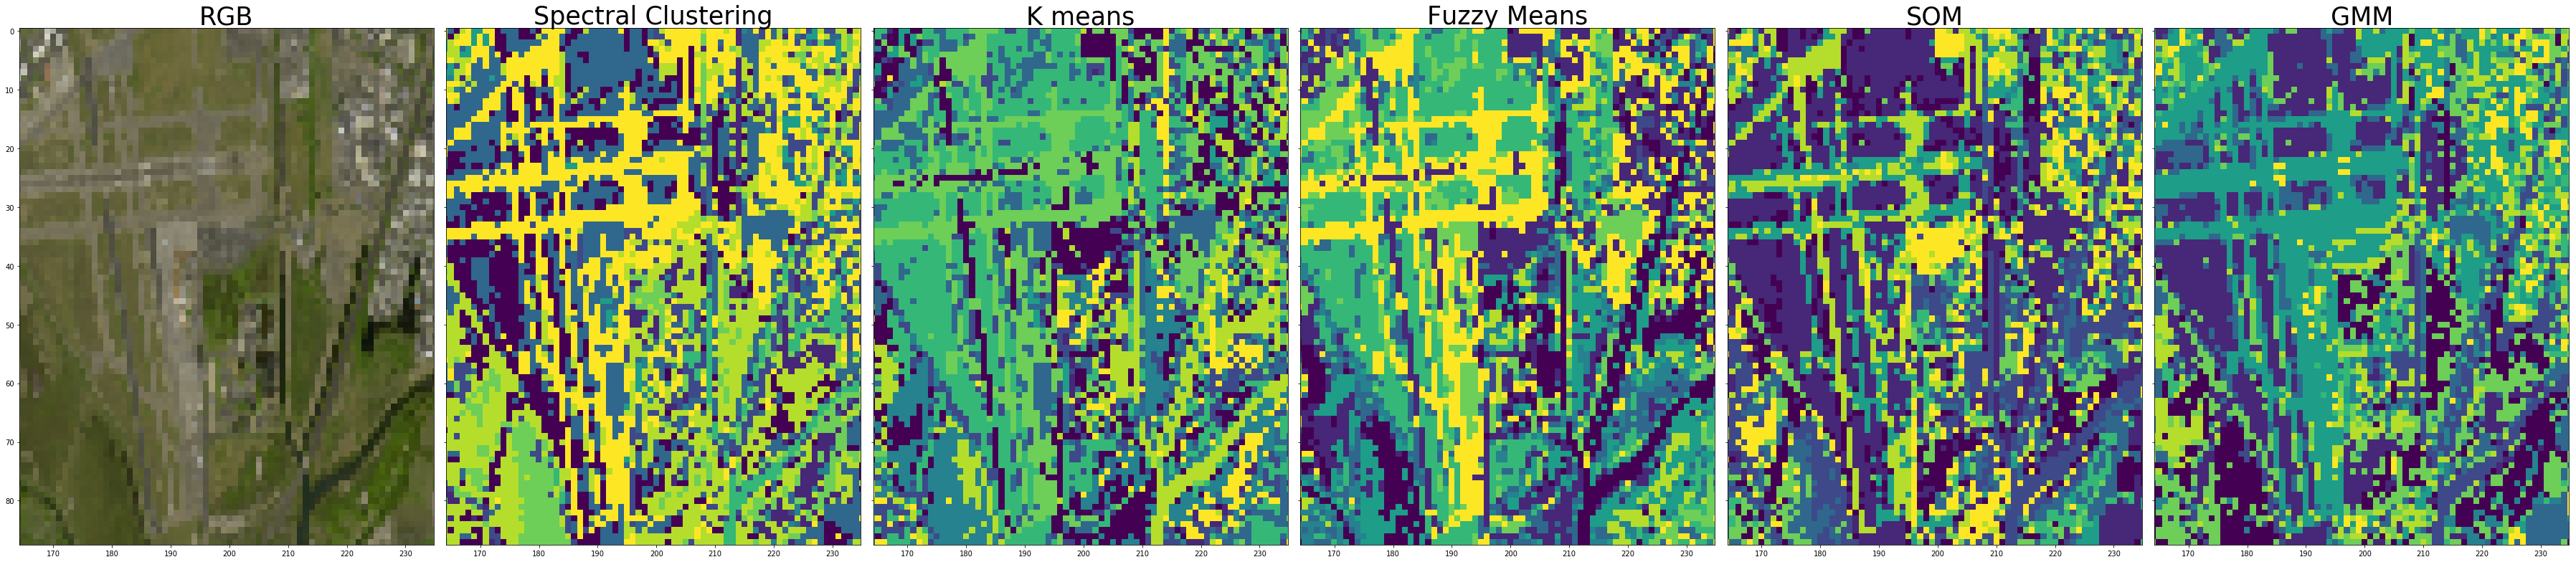

In [7]:
img = sanbar['rgb']
shape = img.shape
plt.figure(1010)
f, axes = plt.subplots(1, 6, sharey=True,figsize=(50,11))
axes[0].imshow(sanbar['rgb'])
axes[0].set_title('RGB', fontsize=35)


# Dimensionality Reduction for Hyperimage 
img = sanbar['hyperimage']
n_components = 5
shape = img.shape
hyper = img.flatten().reshape(shape[0]*shape[1],shape[2])
pca = PCA(n_components=n_components, svd_solver='auto').fit(hyper)
img = pca.transform(hyper).reshape(shape[0],shape[1],n_components)
    
# Resetting Shape in case input was hyper image and underwent dimensionality reduction 
shape = img.shape

[l,w,h] = img.shape
down = img.reshape(l*w,h)
sp = cluster.SpectralClustering(n_clusters=10, eigen_solver='arpack', affinity="nearest_neighbors")
sp.fit_predict(down)
labels = sp.labels_
outlabels = labels.reshape(l,w)

axes[1].imshow(outlabels)
axes[1].set_title('Spectral Clustering', fontsize=35)


n_clusters = 10

KM_out_labels = k_means_clustering(n_clusters=n_clusters, inp_image=img)   
axes[2].imshow(KM_out_labels)
axes[2].set_title('K means', fontsize=35)
       
FM_out_labels = fuzzy_c_means(n_clusters=n_clusters, inp_image=img)   
axes[3].imshow(FM_out_labels)
axes[3].set_title('Fuzzy Means', fontsize=35)

SOM_out_labels = SOM(n_clusters=n_clusters,n_job=5, map_dim=20, inp_image=img)
axes[4].imshow(SOM_out_labels)
axes[4].set_title('SOM', fontsize=35)   

gmm = mixture.GaussianMixture(n_components=10, covariance_type='full', max_iter=20, random_state=0)
gmm.fit(down)
GMM_out_labels = gmm.predict(down)
GMM_out_labels = GMM_out_labels.reshape(l,w)
axes[5].imshow(GMM_out_labels)
axes[5].set_title('GMM', fontsize=35)

f.tight_layout()
f.savefig('SanBar HyperImage Clustering_5.png')

maxtrainlen %d inf
maxtrainlen %d inf


C:\Users\bripo\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


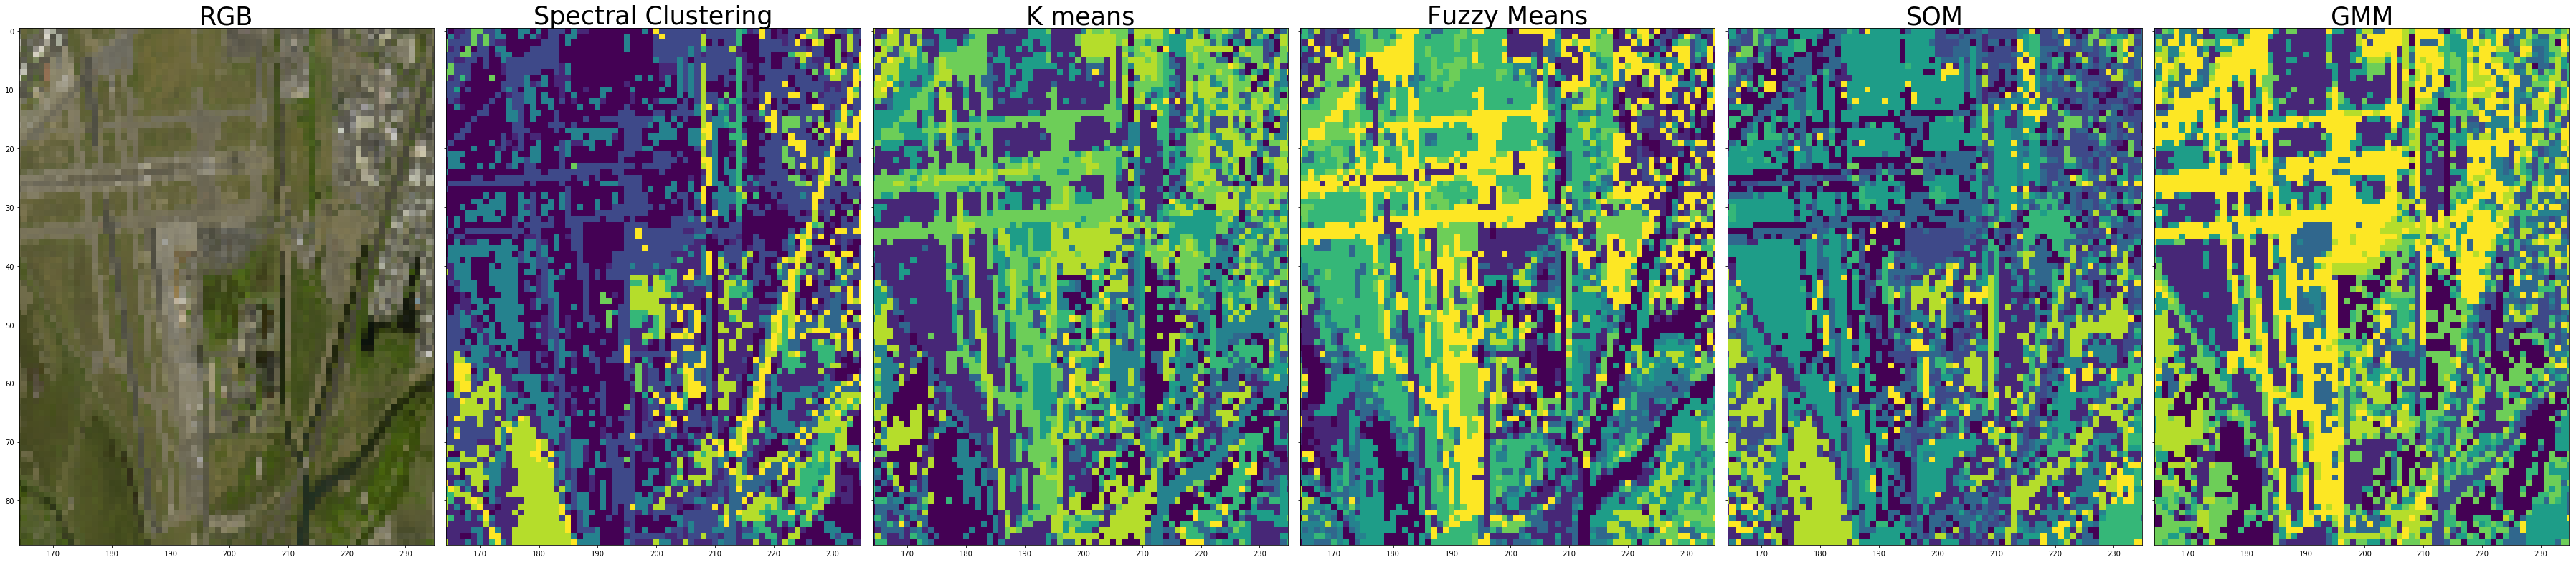

In [8]:
img = sanbar['rgb']
shape = img.shape
plt.figure(1010)
f, axes = plt.subplots(1, 6, sharey=True,figsize=(50,11))
axes[0].imshow(sanbar['rgb'])
axes[0].set_title('RGB', fontsize=35)


# Dimensionality Reduction for Hyperimage 
img = sanbar['hyperimage']
n_components = 8
shape = img.shape
hyper = img.flatten().reshape(shape[0]*shape[1],shape[2])
pca = PCA(n_components=n_components, svd_solver='auto').fit(hyper)
img = pca.transform(hyper).reshape(shape[0],shape[1],n_components)
    
# Resetting Shape in case input was hyper image and underwent dimensionality reduction 
shape = img.shape

[l,w,h] = img.shape
down = img.reshape(l*w,h)
sp = cluster.SpectralClustering(n_clusters=10, eigen_solver='arpack', affinity="nearest_neighbors")
sp.fit_predict(down)
labels = sp.labels_
outlabels = labels.reshape(l,w)

axes[1].imshow(outlabels)
axes[1].set_title('Spectral Clustering', fontsize=35)


n_clusters = 10

KM_out_labels = k_means_clustering(n_clusters=n_clusters, inp_image=img)   
axes[2].imshow(KM_out_labels)
axes[2].set_title('K means', fontsize=35)
       
FM_out_labels = fuzzy_c_means(n_clusters=n_clusters, inp_image=img)   
axes[3].imshow(FM_out_labels)
axes[3].set_title('Fuzzy Means', fontsize=35)

SOM_out_labels = SOM(n_clusters=n_clusters,n_job=5, map_dim=20, inp_image=img)
axes[4].imshow(SOM_out_labels)
axes[4].set_title('SOM', fontsize=35)   

gmm = mixture.GaussianMixture(n_components=10, covariance_type='full', max_iter=20, random_state=0)
gmm.fit(down)
GMM_out_labels = gmm.predict(down)
GMM_out_labels = GMM_out_labels.reshape(l,w)
axes[5].imshow(GMM_out_labels)
axes[5].set_title('GMM', fontsize=35)

f.tight_layout()
f.savefig('SanBar HyperImage Clustering_8.png')